# Check whether a SMIRNOFF-format force field is able to parametrize a dataset of interest



First, we import several molecules, define global variables, and create a helper function to check for parameterization failures.

In [1]:
from openforcefield.topology import Molecule, Topology
from openforcefield.typing.engines.smirnoff import (ForceField, 
UnassignedValenceParameterException, BondHandler, AngleHandler,
ProperTorsionHandler, ImproperTorsionHandler,
vdWHandler)
from simtk import unit
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import IPythonConsole 
from IPython.display import display
import time

# Define "super generics", which are parameters that will match
# each instance of a valence type, such that parametrization
# will not raise a "missing parameter" error when they are defined.
super_generics = {'Bonds': 
                   BondHandler.BondType(smirks='[*:1]~[*:2]', 
                                       k=0*unit.kilocalorie/unit.mole/unit.angstrom**2,
                                       length=0*unit.angstrom
                                       ),
                 'Angles': 
                   AngleHandler.AngleType(smirks='[*:1]~[*:2]~[*:3]',
                                          angle=0*unit.degree,
                                          k=0*unit.kilocalorie/unit.mole/unit.degree**2
                                          ),
                 'ProperTorsions': 
                   ProperTorsionHandler.ProperTorsionType(smirks='[*:1]~[*:2]~[*:3]~[*:4]',
                                                          phase1=0*unit.degree,
                                                          periodicity1=0,
                                                          k1=0*unit.kilocalorie/unit.mole,
                                                          idivf1=1
                                                         ),
                 'ImproperTorsions': 
                   ImproperTorsionHandler.ImproperTorsionType(smirks='[*:1]~[*:2](~[*:3])~[*:4]',
                                                              phase1=0*unit.degree,
                                                              periodicity1=0,
                                                              k1=0*unit.kilocalorie/unit.mole,
                                                              idivf1=1
                                                              ),
                 'vdW': 
                   vdWHandler.vdWType(smirks='[*:1]',
                                      rmin_half=0*unit.angstrom,
                                      epsilon = 0*unit.kilocalorie/unit.mole
                                     ),
                 }

In [2]:
def report_missing_parameters(molecule, forcefield):
    """
    Analyze a molecule using a provided ForceField, generating a report of any
    chemical groups in the molecule that are lacking parameters.
    
    Parameters
    ----------
    molecule : an openforcefield.topology.FrozenMolecule
        The molecule to analyze
    forcefield : an openforcefield.typing.engine.smirnoff.ForceField
        The ForceField object to use
        
    Returns
    -------
    missing_parameters : dict[tagname: list[dict[tagged_smiles:string, image:PIL.Image, atom indices:list[int]]]]
        A hierarchical dictionary, with first level keys indicating ForceField tag 
        names (eg. "Bonds"), and first-level values which are lists of dictionaries. 
        Each dictionary in this list reflects one missing parameter, and contains the 
        following key:value pairs :
        * "image": PIL.Image 
            * shows a 2D drawing, highlighting the feature that could not be parametrized
        * "tagged_smiles": string
            * SMILES of the whole molecule, tagging the atom indices which could not be
              parametrized
        * "atom_indices": tuple(int)
            * The indices of atoms which could not be parametrized
    
    """
    from copy import deepcopy
    bright_purple_rgb = (0.75, 0.25, 0.75)
        

    # Make deepcopies of both inputs, since we may modify them in this function
    forcefield = deepcopy(forcefield)
    molecule = deepcopy(molecule)
    
    # Set partial charges to placeholder values so that we can skip AM1-BCC 
    # during parameterization
    molecule.partial_charges = (np.zeros(molecule.n_atoms) + 0.1) * unit.elementary_charge

    # Prepare dictionary to catch parameterization failure info
    success = False
    missing_params = {}

    while not(success):
        # Try to parameterize the system, catching the exception if there is one.
        try:
            time_i = time.time()
            forcefield.create_openmm_system(molecule.to_topology(), 
                                    charge_from_molecules=[molecule])
            print(f'System creation took {time.time()-time_i} seconds')
            success = True
        except UnassignedValenceParameterException as e:      
            success = False

            # Ensure that there is a list initialized for missing parameters 
            # under this tagname
            handler_tagname = e.handler_class._TAGNAME
            if handler_tagname not in missing_params:
                missing_params[handler_tagname] = []

            # Create a shortcut to the topology atom tuples attached to 
            # the parametrization error
            top_atom_tuples =  e.unassigned_topology_atom_tuples
    
            # Make a summary of the missing parameters from this attempt and add it to 
            # the missing_params dict
            rdmol = molecule.to_rdkit()
            for top_atom_tuple in top_atom_tuples:
                atom_indices = [i.topology_atom_index for i in top_atom_tuple]
                
                # Produce tagged SMILES, using a copy of the RDMol so that 
                # tags aren't attached to the original
                this_rdmol = deepcopy(rdmol)
                this_rdmol.Compute2DCoords()
                for tag_idx, i in enumerate(atom_indices):
                    rdatom = this_rdmol.GetAtomWithIdx(i)
                    rdatom.SetAtomMapNum(tag_idx+1)
                tagged_smiles = Chem.MolToSmiles(this_rdmol)
                
                # Create a 2D drawing of the molecule, highlighting the 
                # parametrization failure
                high_atom_map = {i:bright_purple_rgb for i in atom_indices}
                image = Draw.MolToImage(this_rdmol, 
                                        highlightMap=high_atom_map,
                                       size=(600,600))

                # Structure and append the relevant info to the missing_params dictionary
                param_description = {'atom_indices': atom_indices,
                                     'image': image, 
                                     'tagged_smiles': tagged_smiles
                                    }
                missing_params[handler_tagname].append(param_description)

            # Add a "super generic" parameter to the top of this handler's ParameterList, 
            # which will make it always find parameters for each term. This will prevent the same
            # parameterization exception from being raised in the next attempt.
            param_list = forcefield.get_parameter_handler(handler_tagname).parameters
            param_list.insert(0, super_generics[handler_tagname])
            
    return missing_params


# Loading the molecule dataset

There are several ways to load molecules into the Open Force Field Toolkit. Below, we show how to load molecule databases from a `.smi`, an `.sdf`, and  `.mol2`. It's important that these databases be a _complete_ representation of the molecules you might simulate, including charge and protonation state.

_Note that loading `.mol2` files is currently only supported using the OpenEye toolkit._

### Option 1: Load a SMILES dataset

In [3]:
#molecules =  Molecule.from_file('example_molecules.smi', allow_undefined_stereo=True)
molecules =  Molecule.from_file('problem_smiles.smi', allow_undefined_stereo=True)
print(f'Loaded {len(molecules)} molecules')

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 31, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 30, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 26, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 32, aromatic: False, chiral: False

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 2, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 1, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 15, name: , idx: 9, a

Loaded 976 molecules


### Option 2: Load an SDF dataset 

In [ ]:
molecules =  Molecule.from_file('example_molecules.sdf', allow_undefined_stereo=True)
print(f'Loaded {len(molecules)} molecules')

### Option 3: Load a mol2 dataset 
**This option requires the OpenEye Toolkit!!**

In [ ]:
molecules =  Molecule.from_file('example_molecules.mol2', allow_undefined_stereo=True)
print(f'Loaded {len(molecules)} molecules')

## Analyze all molecules in the data set

### Option 1: Live visualization (single thread: ~1 molecule per second)

Here, we run the above-defined function on all molecules in the dataset. The parameterization failures will be shown in the notebook as the data set is processed. 

_Note: If the dataset is very large, displaying all parameterization failures may cause resource problems in the notebook. If analyzing more than ~10,000 molecules, consider commenting out the `display()` line._


Processing "molecule_1" with smiles [H]c1c(c(c(c(c1[H])[H])[H])[H])[H]
System creation took 0.20751309394836426 seconds

Processing "molecule_2" with smiles [H]c1c(c(c(c(c1Cl)[H])Cl)[H])C(=O)N=P(C(C([H])([H])[H])(C([H])([H])[H])[Hg]C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])N(C([H])([H])[H])C([H])([H])[H]
System creation took 0.5782058238983154 seconds
vdW
[H]C1=C(Cl)C([H])=C(C(=O)N=P(N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])C(C([H])([H])[H])(C([H])([H])[H])[Hg:1]C([H])([H])[H])C([H])=C1Cl


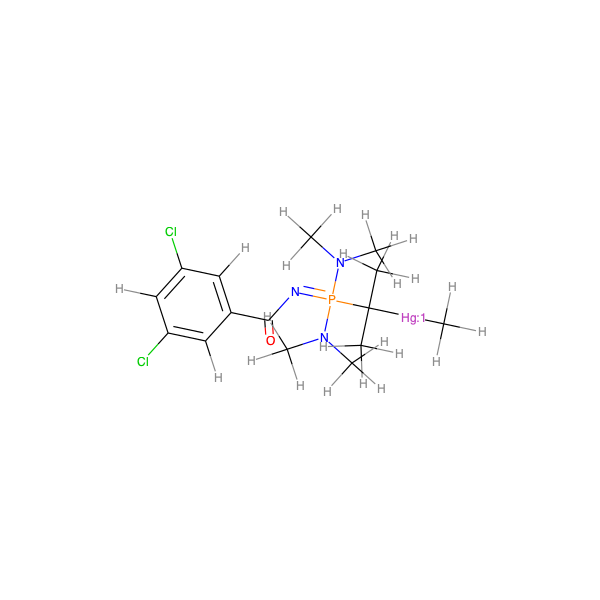

ProperTorsions
[H]C1=C(Cl)C([H])=C(C(=O)N=P(N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])[C:1](C([H])([H])[H])(C([H])([H])[H])[Hg:2][C:3]([H])([H])[H:4])C([H])=C1Cl


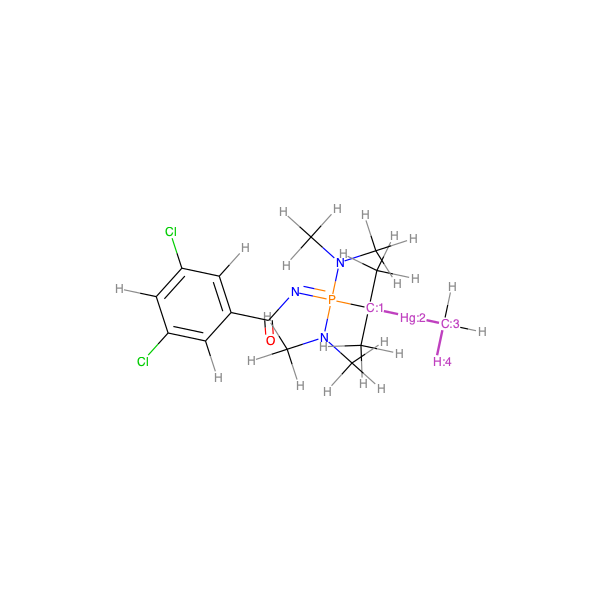

[H]C1=C(Cl)C([H])=C(C(=O)N=P(N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])[C:3](C([H])([H])[H])([Hg:2][C:1]([H])([H])[H])[C:4]([H])([H])[H])C([H])=C1Cl


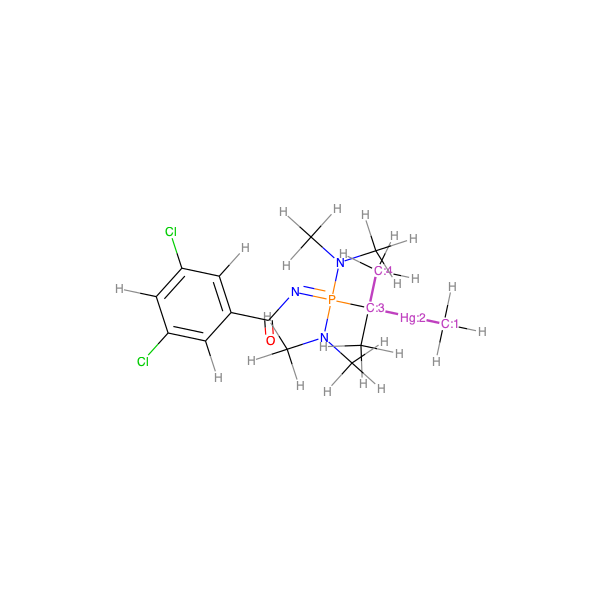

[H]C1=C(Cl)C([H])=C([C:1](=O)[N:2]=[P:3](N(C([H])([H])[H])C([H])([H])[H])(C([Hg]C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])[N:4](C([H])([H])[H])C([H])([H])[H])C([H])=C1Cl


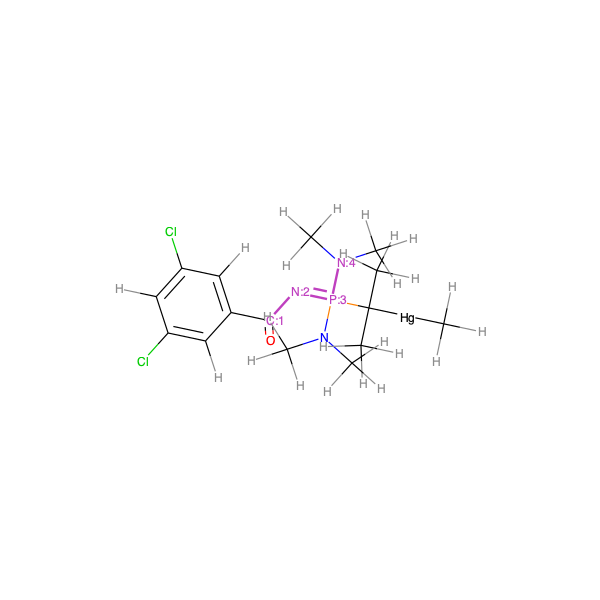

[H]C1=C(Cl)C([H])=C([C:4](=O)[N:3]=[P:2](N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])[C:1]([Hg]C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C([H])=C1Cl


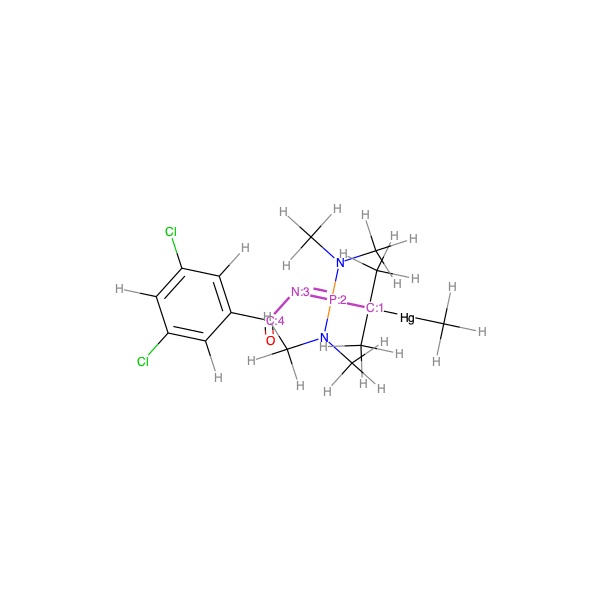

[H]C1=C(Cl)C([H])=C(C(=O)N=[P:4](N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])[C:3](C([H])([H])[H])(C([H])([H])[H])[Hg:2][C:1]([H])([H])[H])C([H])=C1Cl


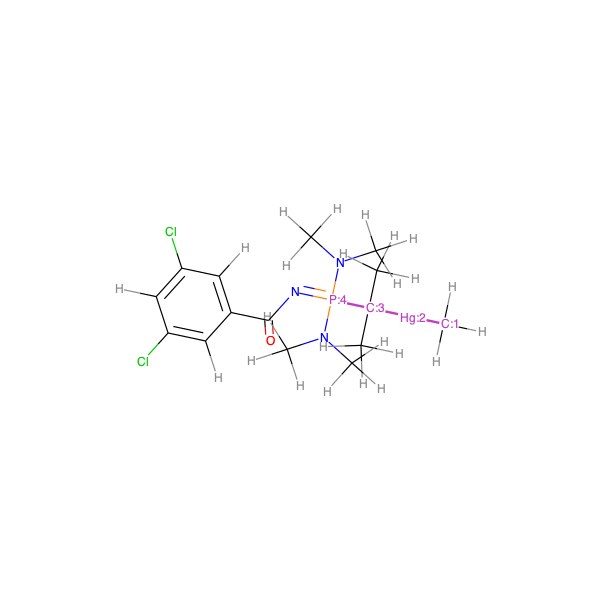

[H]C1=C(Cl)C([H])=C(C(=O)N=P(N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])[C:1](C([H])([H])[H])(C([H])([H])[H])[Hg:2][C:3]([H])([H])[H:4])C([H])=C1Cl


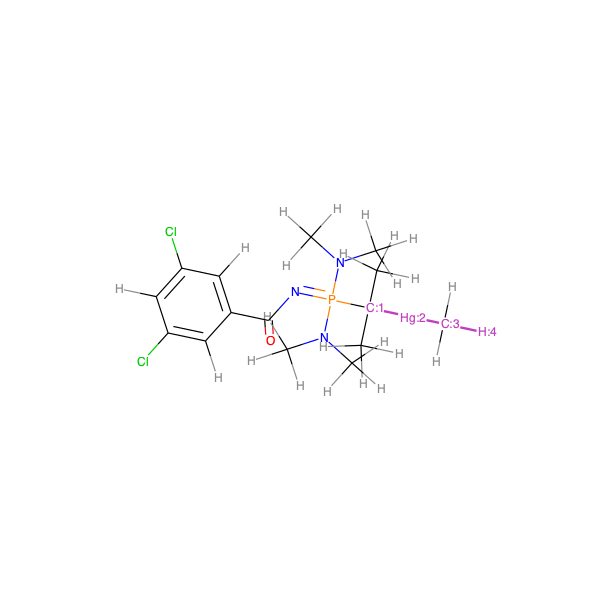

[H]C1=C(Cl)C([H])=C(C(=O)N=P(N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])[C:1](C([H])([H])[H])(C([H])([H])[H])[Hg:2][C:3]([H])([H])[H:4])C([H])=C1Cl


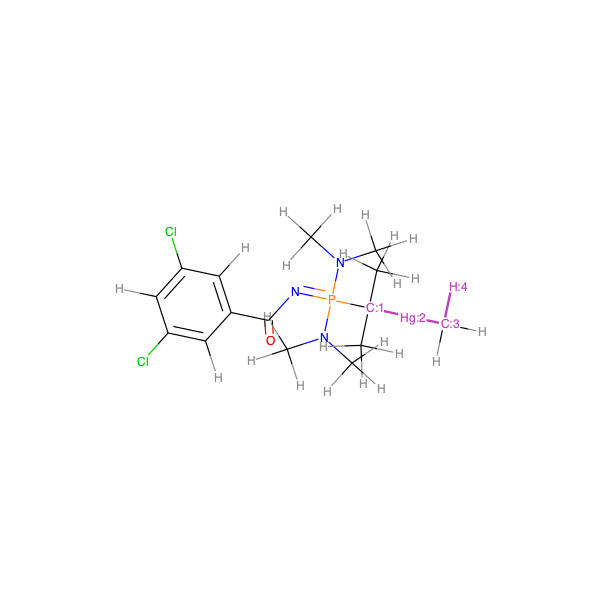

[H]C1=C(Cl)C([H])=C([C:1](=O)[N:2]=[P:3](N(C([H])([H])[H])C([H])([H])[H])(C([Hg]C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])[N:4](C([H])([H])[H])C([H])([H])[H])C([H])=C1Cl


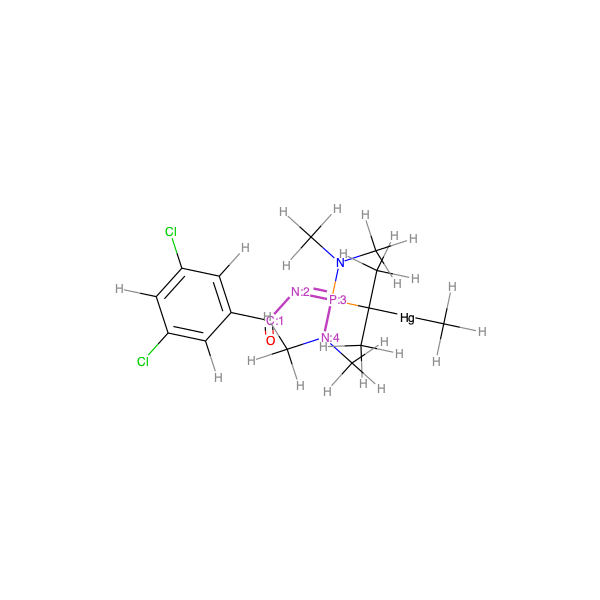

[H]C1=C(Cl)C([H])=C(C(=O)N=P(N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])[C:3](C([H])([H])[H])([Hg:2][C:1]([H])([H])[H])[C:4]([H])([H])[H])C([H])=C1Cl


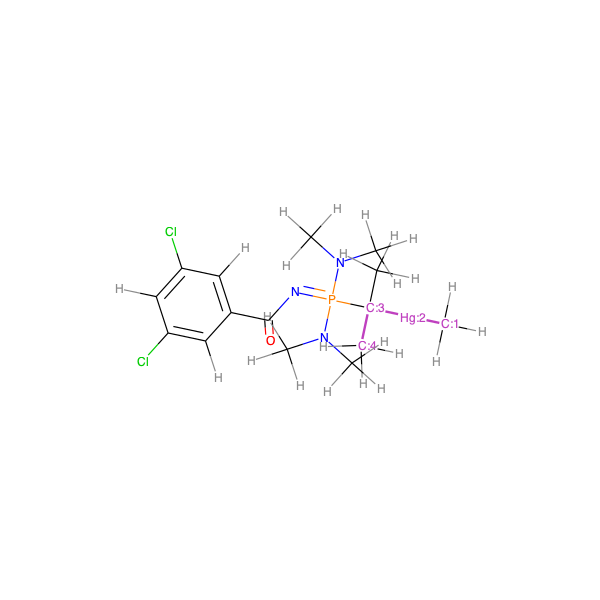

Angles
[H]C1=C(Cl)C([H])=C(C(=O)N=P(N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])[C:3](C([H])([H])[H])(C([H])([H])[H])[Hg:2][C:1]([H])([H])[H])C([H])=C1Cl


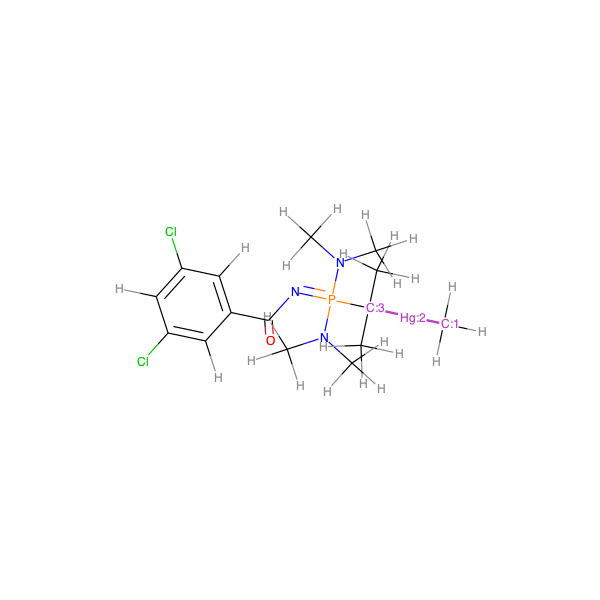

Bonds
[H]C1=C(Cl)C([H])=C(C(=O)N=P(N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])[C:2](C([H])([H])[H])(C([H])([H])[H])[Hg:1]C([H])([H])[H])C([H])=C1Cl


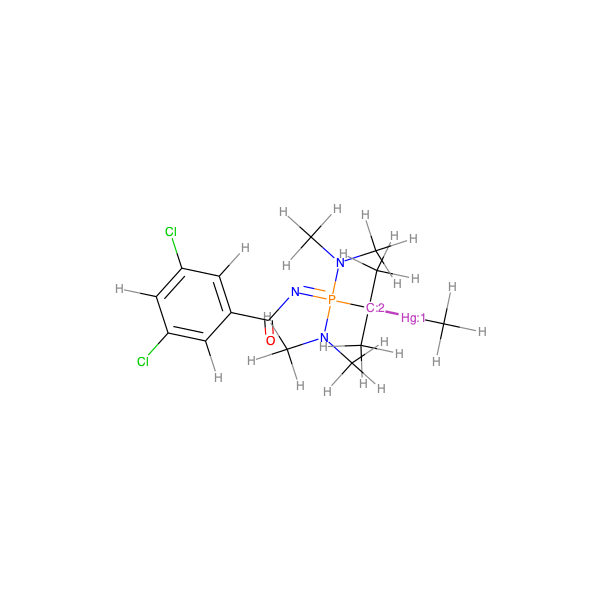

[H]C1=C(Cl)C([H])=C(C(=O)N=P(N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])C(C([H])([H])[H])(C([H])([H])[H])[Hg:2][C:1]([H])([H])[H])C([H])=C1Cl


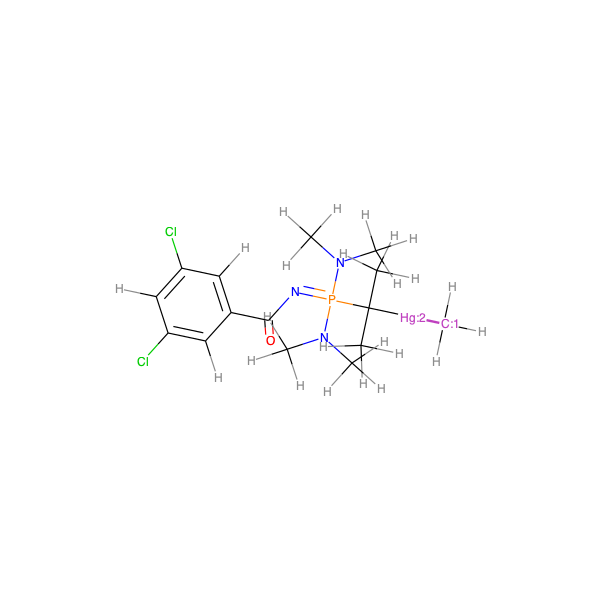


Processing "molecule_3" with smiles [H]c1c(c(c(c(c1[H])[H])C2=c3nc(c(c([n+]3=C(S2)SC([H])([H])[H])C([H])([H])[H])[H])C([H])([H])[H])[H])[H]
System creation took 0.3991212844848633 seconds
ProperTorsions
[H]C1=C([H])C([H])=C(C2=[C:1]3N=C(C([H])([H])[H])C([H])=C(C([H])([H])[H])[N+:2]3=[C:3](SC([H])([H])[H])[S:4]2)C([H])=C1[H]


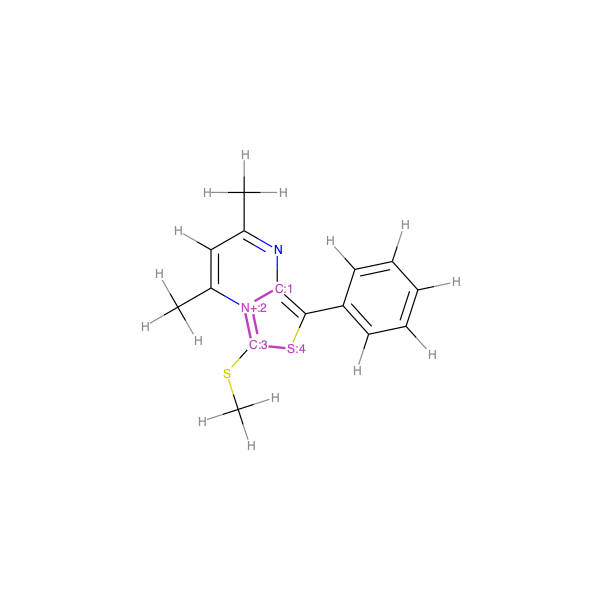

[H]C1=C([H])C([H])=C(C2=[C:1]3N=C(C([H])([H])[H])C([H])=C(C([H])([H])[H])[N+:2]3=[C:3]([S:4]C([H])([H])[H])S2)C([H])=C1[H]


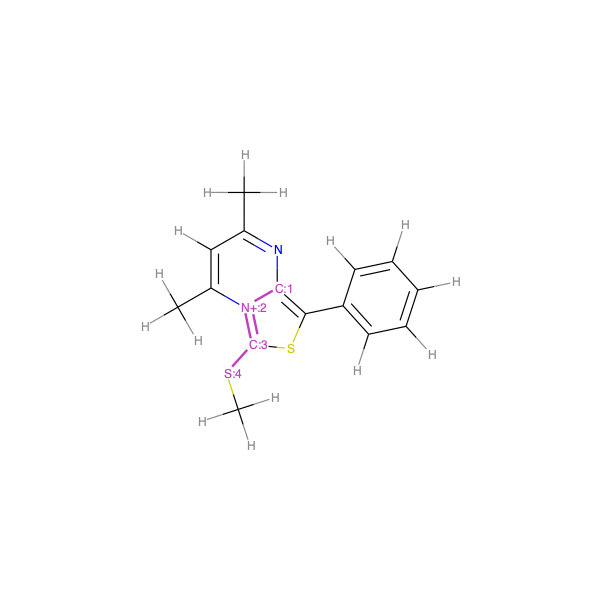

[H]C1=C([H])C([H])=C(C2=C3N=C(C([H])([H])[H])C([H])=[C:1](C([H])([H])[H])[N+:2]3=[C:3]([S:4]C([H])([H])[H])S2)C([H])=C1[H]


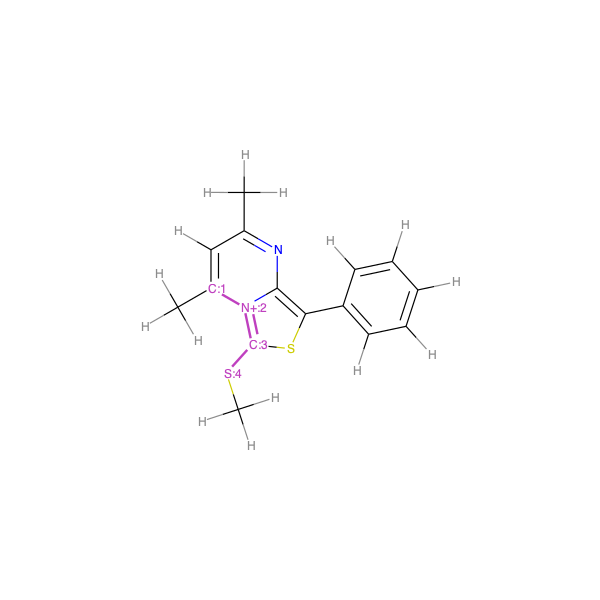

[H]C1=C([H])C([H])=C(C2=C3N=C(C([H])([H])[H])C([H])=[C:1](C([H])([H])[H])[N+:2]3=[C:3](SC([H])([H])[H])[S:4]2)C([H])=C1[H]


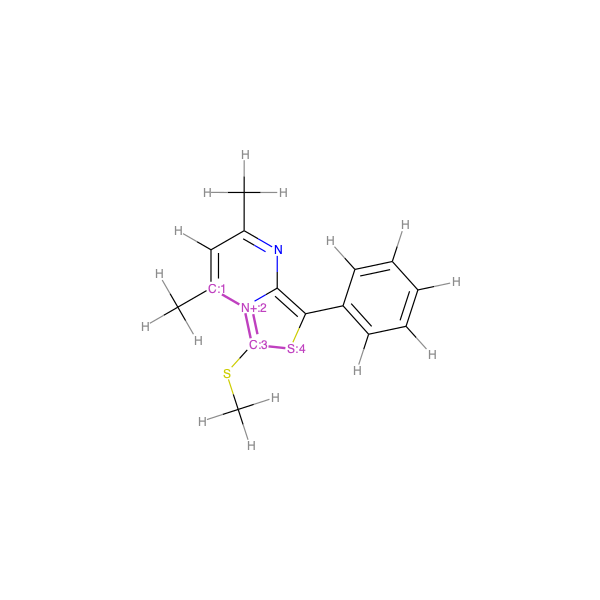


Processing "molecule_4" with smiles [H]C([H])(C([H])([H])OP1(=NP(=NP(=N1)(OC([H])([H])C([H])([H])C(F)(F)F)OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)OC([H])([H])C([H])([H])C(F)(F)F)OC([H])([H])C([H])([H])C(F)(F)F)C(F)(F)F
System creation took 0.7709360122680664 seconds
ProperTorsions
[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:3](OC([H])([H])C([H])([H])C(F)(F)F)([O:4]C([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


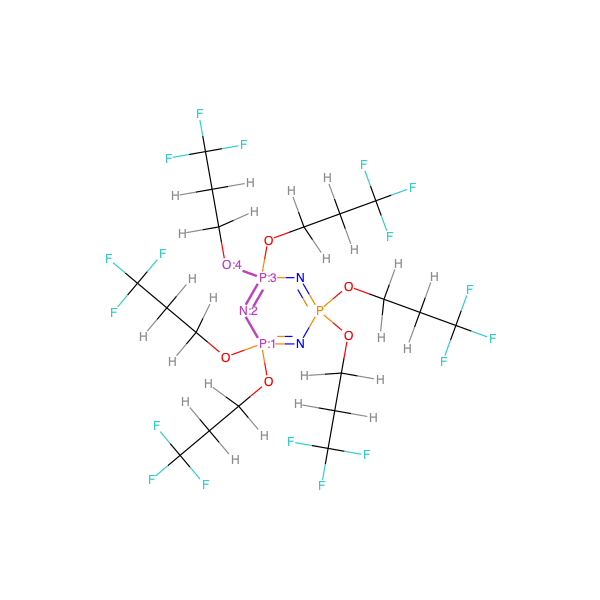

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:3](OC([H])([H])C([H])([H])C(F)(F)F)([O:4]C([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


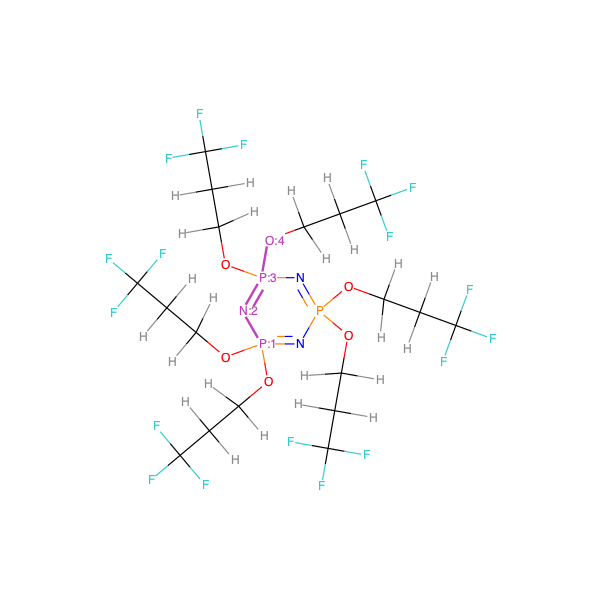

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=[N:4][P:3](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


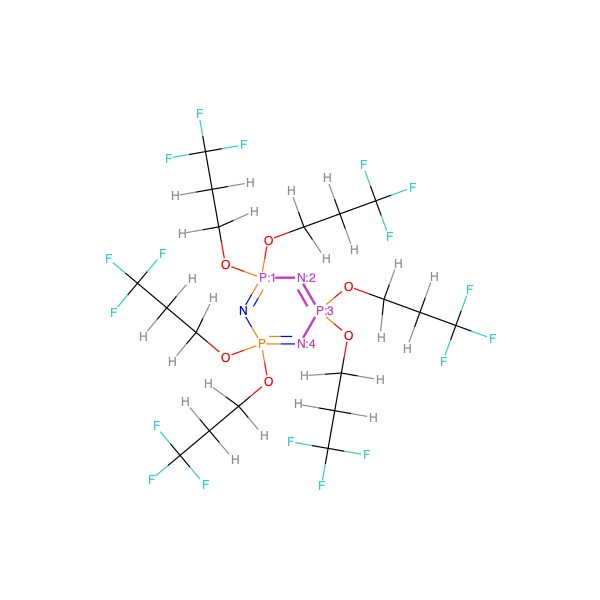

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=[N:4][P:3](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


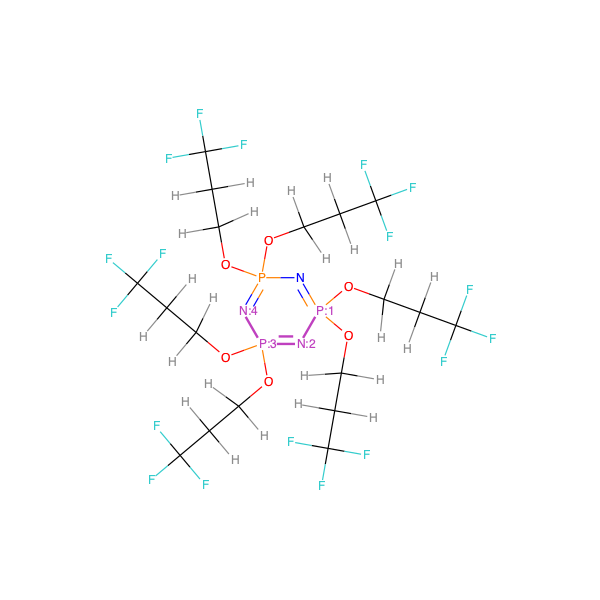

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:3](OC([H])([H])C([H])([H])C(F)(F)F)([O:4]C([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


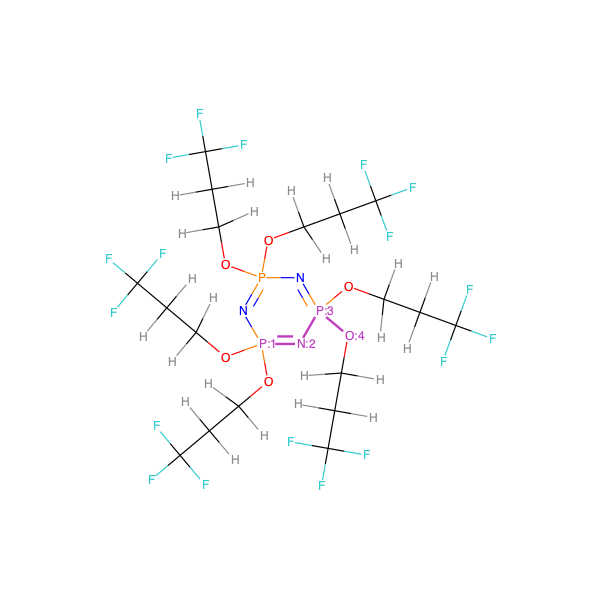

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:3](OC([H])([H])C([H])([H])C(F)(F)F)([O:4]C([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


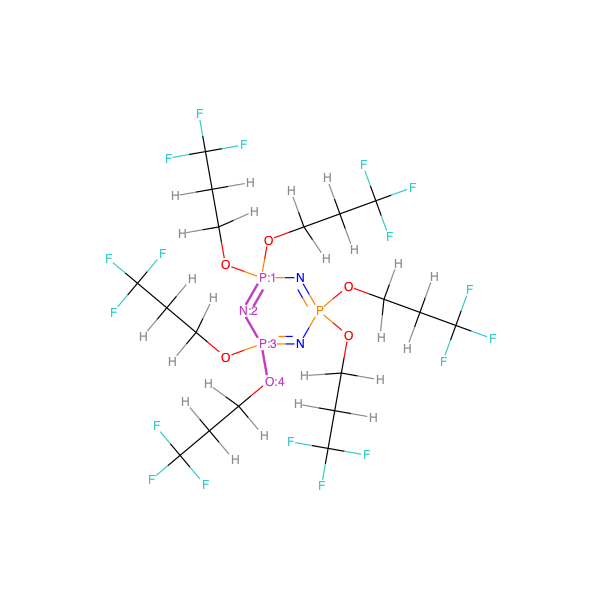

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:3](OC([H])([H])C([H])([H])C(F)(F)F)([O:4]C([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


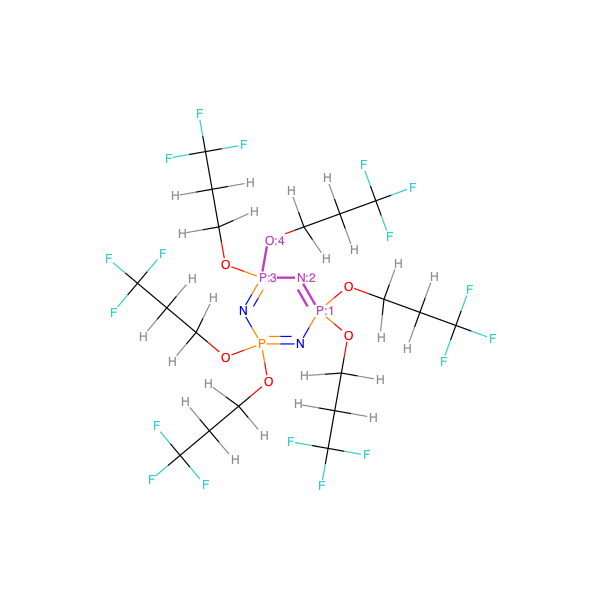

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:3](OC([H])([H])C([H])([H])C(F)(F)F)([O:4]C([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


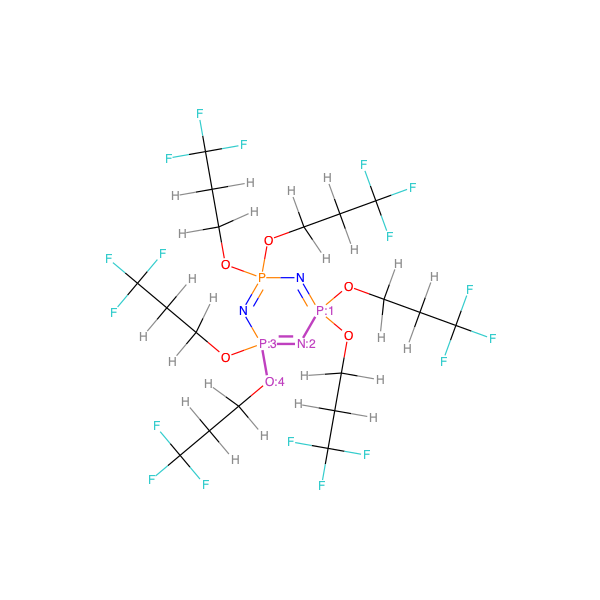

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:3](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:4]1)C([H])([H])C(F)(F)F


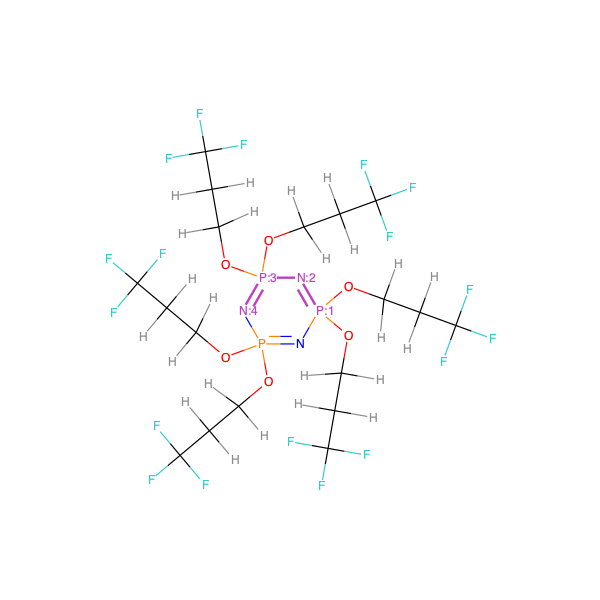

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:4](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:3][P:2](OC([H])([H])C([H])([H])C(F)(F)F)([O:1]C([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


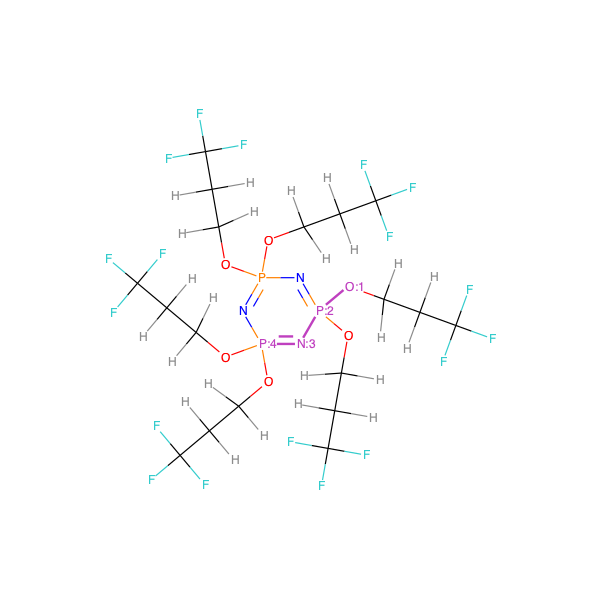

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:4](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:3][P:2](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:1]1)C([H])([H])C(F)(F)F


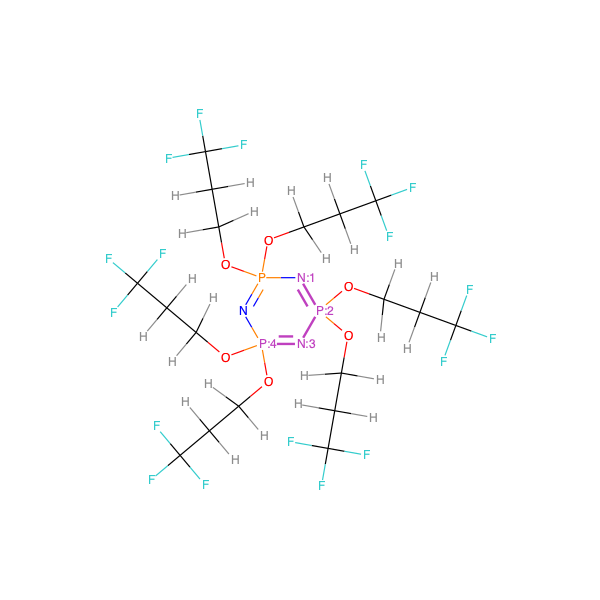

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:3](OC([H])([H])C([H])([H])C(F)(F)F)([O:4]C([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


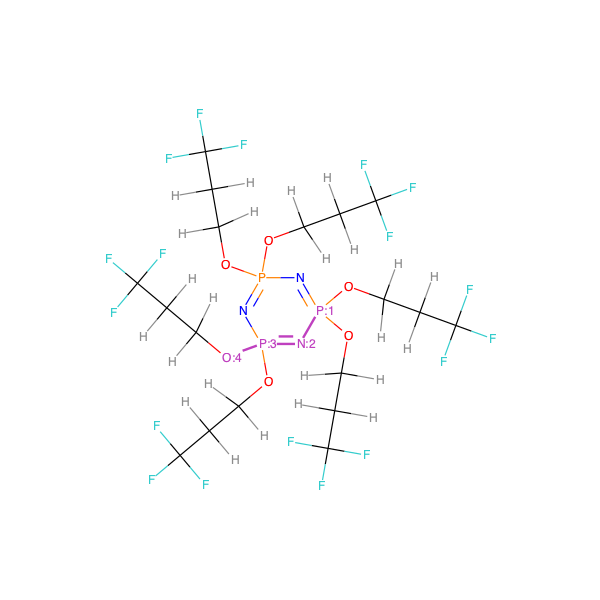

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:3](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:4]1)C([H])([H])C(F)(F)F


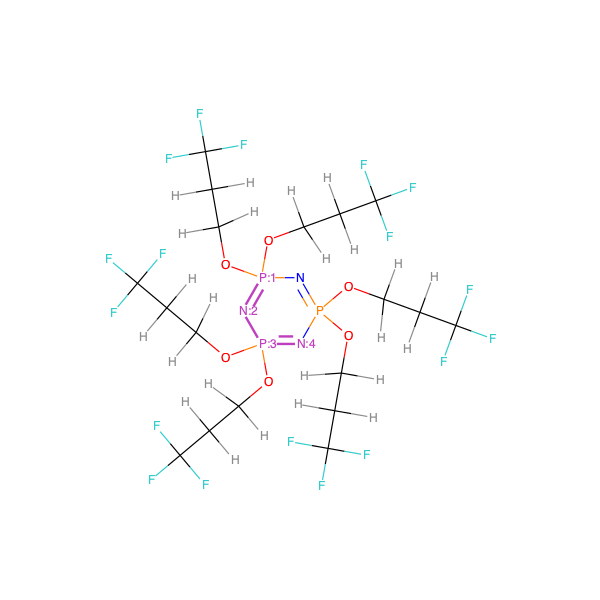

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:2](OC([H])([H])C([H])([H])C(F)(F)F)([O:1]C([H])([H])C([H])([H])C(F)(F)F)=[N:3][P:4](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


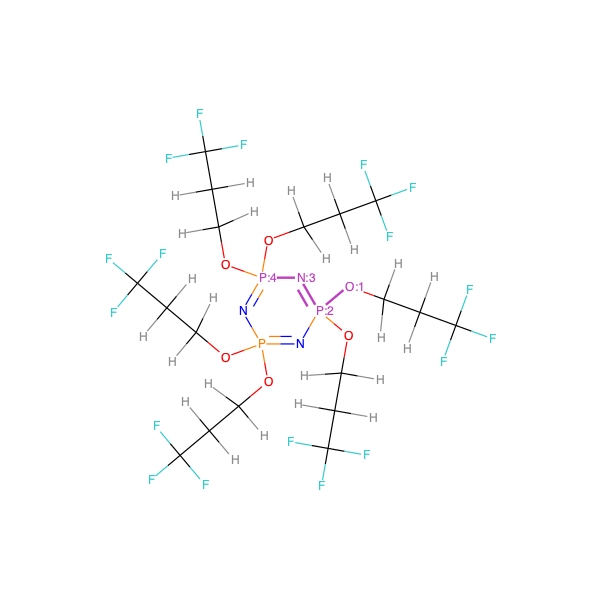

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:3](OC([H])([H])C([H])([H])C(F)(F)F)([O:4]C([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


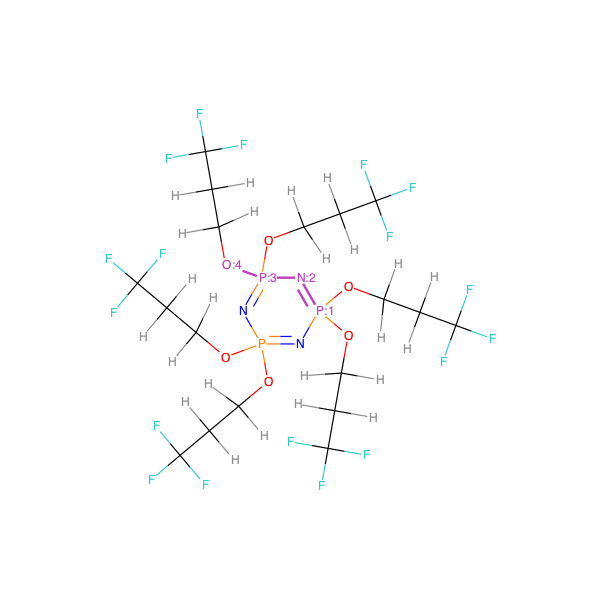

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:3](OC([H])([H])C([H])([H])C(F)(F)F)([O:4]C([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


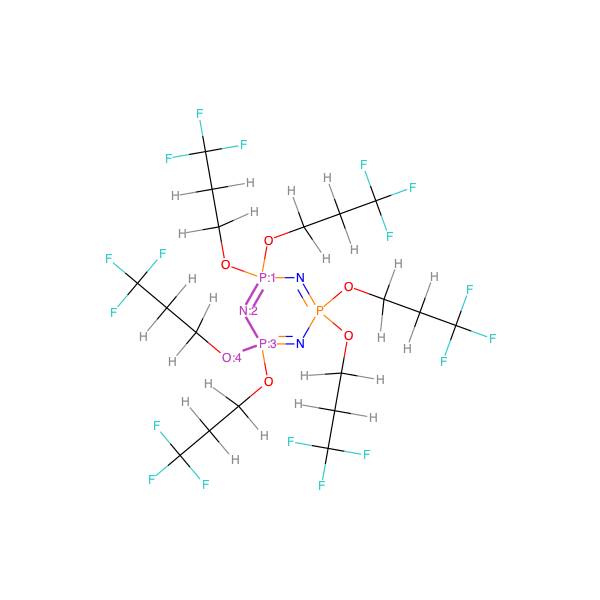

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:3](OC([H])([H])C([H])([H])C(F)(F)F)([O:4]C([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


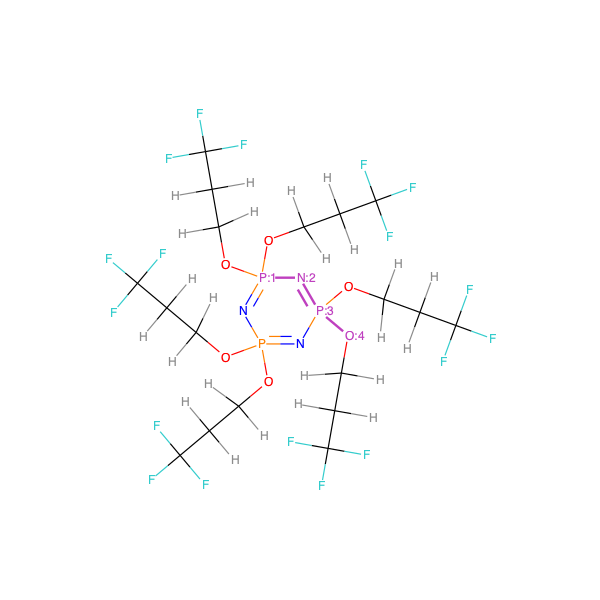

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=[N:1][P:2](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:3][P:4](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


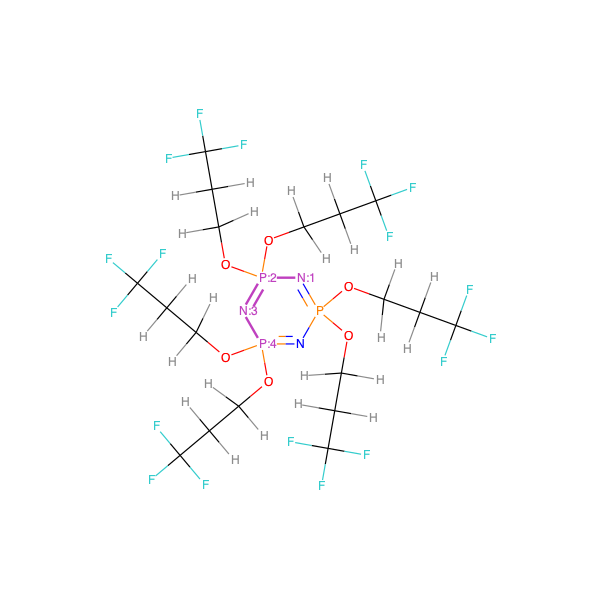

Processing 4 molecules took 6.302142858505249 seconds


In [5]:
start_time = time.time()
forcefield = ForceField('smirnoff99Frosst-1.1.0.offxml')

results = {}

for mol_idx, molecule in enumerate(molecules):
    # Prepare a title for this molecule
    if molecule.name == '':
        mol_name = f'molecule_{mol_idx+1}'
    else:
        mol_name = molecule.name
    print()
    print(f'Processing "{mol_name}" with smiles {molecule.to_smiles()}')
    
    # Analyze missing parameters
    missing_params = report_missing_parameters(molecule, forcefield)
    results[mol_name] = missing_params
    for tagname, missing_tag_params in missing_params.items():
        print(tagname)
        for missing_param in missing_tag_params:
            print(missing_param['tagged_smiles'])
            display(missing_param['image'])

print(f'Processing {len(molecules)} molecules took {time.time()-start_time} seconds')

### Option 2: No live visualization (multiple threads: ~1/num_threads molecules per second)

Output will still be written to file in the final cell of the notebook.

In [7]:
from multiprocessing import Pool

num_threads = 4

def check_molecule(inputs):
    mol_idx = inputs[0]
    molecule = inputs[1]
    forcefield = ForceField('smirnoff99Frosst-1.1.0.offxml')

    # Prepare a title for this molecule
    if molecule.name == '':
        mol_name = f'molecule_{mol_idx+1}'
    else:
        mol_name = molecule.name
    print(f'Processing "{mol_name}" with smiles {molecule.to_smiles()}')
    
    # Analyze missing parameters
    missing_params = report_missing_parameters(molecule, forcefield)
    return (mol_name, missing_params)
            
    
start_time = time.time()
p = Pool(num_threads)
job_args = [(idx, molecule) for idx, molecule in enumerate(molecules)]
result_list = p.map(check_molecule, job_args)
results = dict(result_list)
    

print(f'Processing {len(molecules)} molecules took {time.time()-start_time} seconds')

Processing "molecule_62" with smiles [H]C([H])([H])OP1(=NP(=NP(=N1)(OC([H])([H])[H])OC([H])([H])[H])(OC([H])([H])[H])OC([H])([H])[H])OC([H])([H])[H]
Processing "molecule_1" with smiles [H]c1c(c(c(c(c1[H])N=P(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])N2C(C(OC(C2([H])[H])([H])[H])([H])[H])([H])[H])[H])C(F)(F)F)[H]
Processing "molecule_123" with smiles [H]c1c(c(c(c(c1[H])[H])C([H])([H])/[N+](=N/OC([H])([H])c2c(c(c(c(c2[H])[H])[H])[H])[H])/[O-])[H])[H]
Processing "molecule_184" with smiles [H]c1c(c(c(c(c1C([H])([H])[H])N=P(C2=C(C(=C(O2)C([H])([H])[H])[H])[H])(N3C(C(OC(C3([H])[H])([H])[H])([H])[H])([H])[H])N4C(C(OC(C4([H])[H])([H])[H])([H])[H])([H])[H])[H])[N+](=O)[O-])[H]
System creation took 1.2112250328063965 seconds
System creation took 1.1909921169281006 seconds
Processing "molecule_124" with smiles [H]c1c(c(c(c(c1OC([H])([H])[H])O[H])OC([H])([H])[H])[H])C2=[O+]c3c(c(c(c(c3C(=C2O[H])[H])O[H])[H])O[H])[H]
System creation took 1.5362

System creation took 1.501582145690918 seconds
Processing "molecule_10" with smiles [H][C@]1([C@@]([C@@](O[C@@]([C@@]1([H])OC(=O)C([H])([H])[H])([H])OBr)([H])C([H])([H])OC(=O)C([H])([H])[H])([H])OC(=O)C([H])([H])[H])OC(=O)C([H])([H])[H]
Processing "molecule_71" with smiles [H]c1c(c(c(c(c1OC([H])([H])C(=O)N=P(C2(C(C(C(C(C2([H])[H])([H])[H])([H])[H])([H])[H])([H])[H])[H])(N3C(C(OC(C3([H])[H])([H])[H])([H])[H])([H])[H])N4C(C(OC(C4([H])[H])([H])[H])([H])[H])([H])[H])Cl)[H])Cl)[H]
Processing "molecule_132" with smiles [H]c1c(c(c(c(c1[H])[H])P(=Nc2nc(nc(n2)N(C([H])([H])[H])C([H])([H])[H])N(C([H])([H])[H])C([H])([H])[H])(c3c(c(c(c(c3[H])[H])[H])[H])[H])c4c(c(c(c(c4[H])[H])[H])[H])[H])[H])[H]
System creation took 1.4717791080474854 seconds
Processing "molecule_193" with smiles [H]c1c(c(c(c(c1[H])[H])/N=N/C(=P(c2c(c(c(c(c2[H])[H])[H])[H])[H])(c3c(c(c(c(c3[H])[H])[H])[H])[H])N=S(=O)(C([H])([H])[H])C([H])([H])[H])C(=O)OC([H])([H])C([H])([H])[H])[H])[H]
System creation took 1.8176038265228271 seco

Processing "molecule_18" with smiles [H]C([H])([H])C([H])([H])C(=O)OBr
System creation took 1.425011157989502 seconds
System creation took 0.6182587146759033 seconds
Processing "molecule_202" with smiles [H]c1c(c(c(c(c1[N+](=O)[O-])[H])N=P(C2=C(N=C3N2C(=C(C(=C3[H])[H])[H])[H])C([H])([H])[H])(N4C(C(OC(C4([H])[H])([H])[H])([H])[H])([H])[H])N5C(C(OC(C5([H])[H])([H])[H])([H])[H])([H])[H])OC([H])([H])[H])[H]
System creation took 2.1125681400299072 seconds
Processing "molecule_19" with smiles [H]c1c(c(c(c(c1[H])Cl)C([H])([H])[N+](C([H])([H])[H])(C([H])([H])[H])/N=C(\[H])/N(C([H])([H])[H])C([H])([H])[H])Cl)[H]
System creation took 1.8112881183624268 seconds
Processing "molecule_80" with smiles [H]c1c(c(c(c(c1[H])[H])C(=O)N([H])C(=S)C(=P(c2c(c(c(c(c2[H])[H])[H])[H])[H])(c3c(c(c(c(c3[H])[H])[H])[H])[H])c4c(c(c(c(c4[H])[H])[H])[H])[H])C#N)[H])[H]
Processing "molecule_142" with smiles [H]c1c(c(c(c(c1[H])[H])P(=Nc2c(c(c(c(c2C([H])([H])[H])[H])[H])[H])[H])(c3c(c(c(c(c3[H])[H])[H])[H])[H])c4c(c(c(c(

System creation took 1.648852825164795 seconds
Processing "molecule_89" with smiles [H]c1c(c(c(c(c1[H])[H])P(=Nc2c(c(c(c(c2[H])[H])/C(=C(\C#N)/C(=O)OC([H])([H])C([H])([H])[H])/[H])[H])[H])(c3c(c(c(c(c3[H])[H])[H])[H])[H])c4c(c(c(c(c4[H])[H])[H])[H])[H])[H])[H]
Processing "molecule_151" with smiles [H]c1c(c(c(c(c1C(=O)N=P(C23C(C4(C(C(C2([H])[H])(C(C(C4([H])[H])(C3([H])[H])[H])([H])[H])[H])([H])[H])[H])([H])[H])(N5C(C(C(C(C5([H])[H])([H])[H])([H])[H])([H])[H])([H])[H])N6C(C(C(C(C6([H])[H])([H])[H])([H])[H])([H])[H])([H])[H])[H])[H])Cl)[H]
System creation took 1.7586190700531006 seconds
System creation took 1.8951070308685303 seconds
Processing "molecule_28" with smiles [H]c1c(c(c(c(c1[H])[H])C(=O)C(=P(c2c(c(c(c(c2[H])[H])[H])[H])[H])(c3c(c(c(c(c3[H])[H])[H])[H])[H])c4c(c(c(c(c4[H])[H])[H])[H])[H])C#N)[H])[H]
Processing "molecule_212" with smiles [H]c1c(c(c(c(c1[H])[H])P(=NC(=O)N([H])[H])(c2c(c(c(c(c2[H])[H])[H])[H])[H])c3c(c(c(c(c3[H])[H])[H])[H])[H])[H])[H]
System creation took 2.032765

System creation took 1.5602061748504639 seconds
Processing "molecule_98" with smiles [H]c1c(c(c(c(c1[H])N=P23C(N4C(N(C2([H])[H])C(N(C4([H])[H])C3([H])[H])([H])[H])([H])[H])([H])[H])OC([H])([H])[H])[H])[H]
System creation took 1.4084279537200928 seconds
System creation took 1.8354871273040771 seconds
Processing "molecule_159" with smiles [H]c1c(c(c(c(c1[H])[H])P2(=NC(=NC(=N2)C(Cl)(Cl)Cl)C(Cl)(Cl)Cl)c3c(c(c(c(c3[H])[H])[H])[H])[H])[H])[H]
Processing "molecule_220" with smiles [H]c1c(c(c(c(c1[H])[H])C2=c3c(=[O+]C(=C2[H])c4c(c(c(c(c4[H])[H])[H])[H])[H])nc(nc3O[H])O[H])[H])[H]
System creation took 1.4393739700317383 seconds
System creation took 1.09415602684021 seconds
System creation took 1.0311639308929443 seconds
Processing "molecule_37" with smiles [H]c1c(c(c(c2=[O+]c3c(c(c(c(c3O[H])O[H])[H])C(=O)O[H])N=c12)[H])N(C([H])([H])[H])C([H])([H])[H])[H]
Processing "molecule_99" with smiles [H]c1c(c(c(c(c1S(=O)(=O)N([H])C([H])([H])C([H])([H])/N=[N+](\C(C([H])([H])[H])(C([H])([H])[H])[N+](=O)[O-

System creation took 1.0917248725891113 seconds
Processing "molecule_46" with smiles [H]c1c(c(c(c(c1[H])[H])N([H])/C(=N/P(=S)(N([H])c2c(c(c(c(c2[H])[H])[H])[H])[H])N([H])c3c(c(c(c(c3[H])[H])[H])[H])[H])/C(C([H])([H])[H])(Cl)Cl)[H])[H]
System creation took 1.3015210628509521 seconds
System creation took 1.5565969944000244 seconds
Processing "molecule_229" with smiles [H]c1c(c(c(c(c1[H])[H])P(=NC2=Nc3c(c(c(c(c3S2)[H])[H])[H])[H])(c4c(c(c(c(c4[H])[H])[H])[H])[H])c5c(c(c(c(c5[H])[H])[H])[H])[H])[H])[H]
Processing "molecule_168" with smiles C1(=C(N(N=C1Br)[N+](=O)[O-])Br)Br
System creation took 1.9808640480041504 seconds
System creation took 0.7414212226867676 seconds
System creation took 1.5443439483642578 seconds
Processing "molecule_109" with smiles [H]c1c(c(c(c(c1[H])[H])C2=c3c4c(c(c(c(c4c(c(c3=[O+]c5c2c6c(c(c(c(c6c(c5[H])[H])[H])[H])[H])[H])[H])[H])[H])[H])[H])[H])[H])[H]
Processing "molecule_169" with smiles [H]c1c(c(c(c(c1[H])[H])P(=C([H])C(=O)C([H])([H])Cl)(c2c(c(c(c(c2[H])[H])[H])[

Processing "molecule_176" with smiles [H]c1c(c(c2c(c1[H])N=C(C3=NN=NN23)/N=N/N=P(N(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])[H])(N(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])[H])N(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])[H])[H])[H]
System creation took 1.2251060009002686 seconds
System creation took 1.4979240894317627 seconds
Processing "molecule_55" with smiles [H]c1c(nc(c(c1C2=C(C(=O)N(C(=N2)N([H])[N+](=O)[O-])[H])[H])[H])[H])[H]
Processing "molecule_238" with smiles [H]C1=C(N=C(N(C1=O)[H])N([H])[N+](=O)[O-])N([H])[H]
System creation took 1.5592401027679443 seconds
System creation took 1.7598981857299805 seconds
System creation took 0.9703559875488281 seconds
System creation took 0.9197921752929688 seconds
Processing "molecule_117" with smiles [H]C([H])([H])C([H])([H])OC(=O)C1=NC(=NN1[H])N([H])[N+](=O)[O-]
Processing "molecule_177" with smiles [H]C([H])([H])N1C(=NC(=N1)[N+](=O)[O-])N(C([H])([H])C(=O)O[H])[N+](=O)[O-]
Processing "molecule_56" with smiles [H]c1c(c(c

System creation took 1.390052080154419 seconds
System creation took 1.207617998123169 seconds
Processing "molecule_429" with smiles [H]c1c(c(c(c(c1[H])[H])N([H])C(=O)N=P(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])(N2C(C(C(C(C(C2([H])[H])([H])[H])([H])[H])([H])[H])([H])[H])([H])[H])N3C(C(C(C(C(C3([H])[H])([H])[H])([H])[H])([H])[H])([H])[H])([H])[H])[H])[H]
Processing "molecule_308" with smiles [H]c1c(nc(c(c1N([H])[N+](=O)[O-])[H])[H])[H]
System creation took 1.744420051574707 seconds
System creation took 0.8056118488311768 seconds
Processing "molecule_248" with smiles [H]c1c(c(c(c(c1[H])C2=c3c(c(c(c(c3=[O+]c4c2c(c(c(c4[H])N([H])C([H])([H])C([H])([H])[H])C([H])([H])[H])[H])[H])N([H])C([H])([H])C([H])([H])[H])C([H])([H])[H])[H])C(=O)OC([H])([H])C([H])([H])[H])[H])[H]
System creation took 1.7523760795593262 seconds
Processing "molecule_309" with smiles [H]c1c(c(c(c(c1[H])[H])P(=C(C(=O)OC([H])([H])C([H])([H])[H])P(=O)(c2c(c(c(c(c2[H])[H])[H])[H])[H])c3c(c(c(c(c3[H])[H])[H])[H])[H])(c4c

System creation took 1.1741037368774414 seconds
Processing "molecule_316" with smiles [H]c1c(c(c(c(c1[H])[H])OP(=O)(N=P(c2c(c(c(c(c2[H])[H])[H])[H])[H])(c3c(c(c(c(c3[H])[H])[H])[H])[H])N([H])c4nc(c(c(n4)[H])[H])[H])Oc5c(c(c(c(c5[H])[H])[H])[H])[H])[H])[H]
Processing "molecule_438" with smiles [H]C1=C(N=C(N1[N+](=O)[O-])[H])[N+](=O)[O-]
Processing "molecule_377" with smiles [H]c1c(c(c(c(c1[H])N([H])C(=S)N=P(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])(N2C(C(C(C(C(C2([H])[H])([H])[H])([H])[H])([H])[H])([H])[H])([H])[H])N3C(C(C(C(C(C3([H])[H])([H])[H])([H])[H])([H])[H])([H])[H])([H])[H])I)[H])[H]
System creation took 0.6155209541320801 seconds
System creation took 1.4694077968597412 seconds
Processing "molecule_439" with smiles [H]c1c(c(c(c(c1[H])[H])P(=Nc2c(c(c(c(c2[H])[H])/C(=C\3/C(=O)N(C(=S)S3)C([H])([H])C([H])([H])[H])/[H])[H])[H])(c4c(c(c(c(c4[H])[H])[H])[H])[H])c5c(c(c(c(c5[H])[H])[H])[H])[H])[H])[H]
Processing "molecule_257" with smiles [H]C1(C(N(C(=O)N1[N+](=O)[O-])[N+](=O)[O-

Processing "molecule_325" with smiles [H]c1c(c(c(c2=[O+]c3c(c(c(c(c3C(=c12)c4c(c(c(c(c4C(=O)OC([H])([H])[H])[H])[H])C(=O)N([H])C([H])([H])C([H])([H])N5C(=O)C(=C(C5=O)[H])[H])[H])[H])[H])N([H])[H])[H])[H])N([H])[H])[H]
System creation took 1.5548169612884521 seconds
System creation took 1.5587949752807617 seconds
System creation took 1.4324469566345215 seconds
Processing "molecule_326" with smiles [H]C1=NN(C(=[N+]1N([H])[N+](=O)[O-])[H])C([H])([H])C(=O)N([H])C2=NN=C(S2)SC([H])([H])C([H])([H])C([H])([H])C([H])([H])[H]
System creation took 1.7612659931182861 seconds
Processing "molecule_448" with smiles [H]C1=C(C(=NN1[N+](=O)[O-])C(=O)OC([H])([H])[H])Cl
Processing "molecule_266" with smiles [H][C@@]1([C@]([C@@]([C@@]([C@@](O1)(C(=O)C([H])([H])[H])OBr)([H])O[H])([H])O[H])([H])O[H])C(=O)OC([H])([H])[H]
Processing "molecule_386" with smiles [H]c1c(c(c(c(c1N=P(C2=C(C(=C(O2)C([H])([H])[H])[H])[H])(N3C(C(C(C(C(C3([H])[H])([H])[H])([H])[H])([H])[H])([H])[H])([H])[H])N4C(C(C(C(C(C4([H])[H])([H])[

Processing "molecule_456" with smiles [H]c1c(c(c2=[O+]C(=C(C(=c2c1[H])OC([H])([H])C([H])([H])[H])[H])c3c(c(c4c(c3[H])OC(C(O4)([H])[H])([H])[H])[H])[H])[H])[H]
System creation took 1.5591602325439453 seconds
System creation took 1.4073381423950195 seconds
Processing "molecule_275" with smiles [H]c1c(c(c(c(c1[H])[H])C2=N/C(=N\P(=O)(N([H])c3c(c(c(c(c3[H])[H])C([H])([H])[H])[H])[H])N([H])c4c(c(c(c(c4[H])[H])C([H])([H])[H])[H])[H])/SN2c5c(c(c(c(c5[H])[H])[H])[H])[H])[H])[H]
System creation took 2.19783616065979 seconds
Processing "molecule_457" with smiles [H]C([H])(C([H])([H])OP1(=NP(=NP(=N1)(OC([H])([H])C([H])([H])C([H])([H])F)OC([H])([H])C([H])([H])C([H])([H])F)(OC([H])([H])C([H])([H])C([H])([H])F)OC([H])([H])C([H])([H])C([H])([H])F)OC([H])([H])C([H])([H])C([H])([H])F)C([H])([H])F
Processing "molecule_336" with smiles [H]c1c(c(nc(c1[H])N([H])[N+](=O)[O-])[H])[H]
System creation took 1.6821949481964111 seconds
Processing "molecule_395" with smiles [H]c1c(c(c(c(c1[H])[H])C2=c3nc(c(c([n+]3=

System creation took 1.2279109954833984 seconds
System creation took 1.317568063735962 seconds
System creation took 1.1682891845703125 seconds
Processing "molecule_346" with smiles [H]C([H])([H])O/N=[N+](/C([H])(Br)Br)\[O-]
Processing "molecule_465" with smiles [H]C1(C(C(OC(O1)(C([H])([H])[H])C([H])([H])[H])([H])[H])(/[N+](=N/C2=NON=C2C([H])([H])[H])/O[H])[N+](=O)[O-])[H]
Processing "molecule_404" with smiles [H]c1c(c(c(c(c1[H])[H])C2=NN=NN2C(=P(c3c(c(c(c(c3[H])[H])[H])[H])[H])(c4c(c(c(c(c4[H])[H])[H])[H])[H])c5c(c(c(c(c5[H])[H])[H])[H])[H])C#N)[H])[H]
System creation took 0.599766731262207 seconds
System creation took 1.634592056274414 seconds
Processing "molecule_347" with smiles [H]c1c(c(c(c2c1c(nc(n2)N([H])[N+](=O)[O-])N([H])[H])[H])C([H])([H])[H])[H]
System creation took 1.19093918800354 seconds
Processing "molecule_285" with smiles [H]c1c(c(c(c(c1OC([H])([H])[H])[H])[H])S(=O)(=O)N(C([H])([H])[H])[N+](=O)[O-])[H]
Processing "molecule_466" with smiles [H]c1c(c(c(c(c1[H])[H])P2(=NC(

System creation took 1.8027448654174805 seconds
Processing "molecule_414" with smiles [H]C([H])(C1=NC(=NN1C([H])([H])O[H])N([H])[N+](=O)[O-])C2=NC(=NN2C([H])([H])O[H])N([H])[N+](=O)[O-]
Processing "molecule_473" with smiles [H]C1=C(C2=C(C(=C(N2C(=C1[H])[H])C(=S)N=P(C3(C(C(C(C(C3([H])[H])([H])[H])([H])[H])([H])[H])([H])[H])[H])(N4C(C(OC(C4([H])[H])([H])[H])([H])[H])([H])[H])N5C(C(OC(C5([H])[H])([H])[H])([H])[H])([H])[H])C([H])([H])[H])[H])[H]
System creation took 1.6375348567962646 seconds
System creation took 1.0072119235992432 seconds
Processing "molecule_295" with smiles [H]C([H])([H])N(C1=C(C(=NP(=N1)(N(C([H])([H])[H])C([H])([H])[H])N(C([H])([H])[H])C([H])([H])[H])C(Cl)(Cl)Cl)C#N)C([H])([H])[H]
System creation took 1.2636711597442627 seconds
Processing "molecule_415" with smiles [H]C1=C(N=C(N(C1=O)[H])N([H])[N+](=O)[O-])C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H]
Processing "molecule_356" with smiles [H]c1c(c(nc(c1C([H])([H])N2C(=NC(C2([H])[H])([H])[H])N([H])[N+](=O)[O-])[H])Cl)

System creation took 0.6998190879821777 seconds
Processing "molecule_304" with smiles [H]C1(C(C(C(C(C1([H])[H])([H])[H])([H])N([H])C2=NON=C2/N=[N+](/C3(C(OC(OC3([H])[H])(C([H])([H])[H])C([H])([H])[H])([H])[H])[N+](=O)[O-])\O[H])([H])[H])([H])[H])[H]
System creation took 1.5517520904541016 seconds
Processing "molecule_424" with smiles [H]c1c(c(c(c(c1[H])[H])C2=NN([N+](=N2)C([H])([H])C(=O)N([H])N([H])[H])[H])[H])[H]
System creation took 1.669499158859253 seconds
System creation took 1.8292710781097412 seconds
Processing "molecule_483" with smiles [H]C1=C(C(=C=C=C1C(=O)N2C(C(N(C(C2([H])[H])([H])[H])C(=O)OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])([H])[H])([H])[H])Cl)[H]
Processing "molecule_365" with smiles [H]c1c(c(c(c(c1[H])Cl)[H])N([H])S(=O)(=O)c2c(c(c(c(c2Cl)[H])[H])N([H])C(=S)N=P(c3c(c(nc(c3[H])[H])[H])[H])(N(C([H])([H])[H])C([H])([H])[H])N(C([H])([H])[H])C([H])([H])[H])[H])[H]
System creation took 0.9417541027069092 seconds
System creation took 1.4399209022521973 seconds
Proce

Processing "molecule_555" with smiles [H]C([H])([H])C(C([H])([H])N(C([H])([H])C([H])([H])C([H])([H])O[N+](=O)[O-])[N+](=O)[O-])([N+](=O)[O-])[N+](=O)[O-]
Processing "molecule_674" with smiles [H]c1c(c(c(c(c1[H])[H])P(=Nc2c(c(c(c(c2[H])[H])C(=O)OC([H])([H])[H])[H])[H])(c3c(c(c(c(c3[H])[H])[H])[H])[H])c4c(c(c(c(c4[H])[H])[H])[H])[H])[H])[H]
System creation took 1.4021880626678467 seconds
System creation took 1.1026711463928223 seconds
Processing "molecule_617" with smiles [H]c1c(c(c(c(c1[H])[S+2](C([H])([H])[H])(C([H])([H])[H])S(=O)(=O)Oc2c(c(c(c(c2[H])[H])C([H])([H])[H])[H])[H])[H])C(=O)O[H])[H]
Processing "molecule_556" with smiles [H]c1c(c(c(c2=[O+]c3c(c(c(c(c3C(=c12)c4c(c(c(c(c4C(=O)O[H])[H])N=C=S)[H])[H])[H])[H])N(C([H])([H])[H])C([H])([H])[H])[H])[H])N(C([H])([H])[H])C([H])([H])[H])[H]
System creation took 2.083019971847534 seconds
System creation took 2.053256034851074 seconds
Processing "molecule_497" with smiles [H]C([H])([H])C(C([H])([H])[H])(/[N+](=N/C1=NON=C1/N=N\C2=NON=C2N([

System creation took 3.0630080699920654 seconds
Processing "molecule_565" with smiles [H]C1(C(C(N(C1([H])[H])/C(=N/P(=O)(N2C(C(C(C2([H])[H])([H])[H])([H])[H])([H])[H])N3C(C(C(C3([H])[H])([H])[H])([H])[H])([H])[H])/C(Cl)(Cl)Cl)([H])[H])([H])[H])[H]
Processing "molecule_505" with smiles [H]C([H])([H])C(C(=O)OC([H])([H])[H])(C([H])([H])[H])/N=[N+](/C(C(=O)OC([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])\O[H]
Processing "molecule_682" with smiles [H]c1c(c(c2c(c1[H])[N@](C(N2C(=O)C([H])([H])/[N+](=N/OC([H])([H])[H])/[O-])([H])[H])S(=O)(=O)c3c(c(c(c(c3[H])[H])F)[H])[H])[H])[H]
System creation took 1.2984211444854736 seconds
System creation took 1.5487277507781982 seconds
System creation took 1.8645679950714111 seconds
System creation took 1.4927880764007568 seconds
Processing "molecule_506" with smiles [H]c1c(c(c(c(c1[H])[H])P(=C(C#N)C(=S)N([H])C(=O)c2c(c(c(c(c2[H])[H])C([H])([H])[H])[H])[H])(c3c(c(c(c(c3[H])[H])[H])[H])[H])c4c(c(c(c(c4[H])[H])[H])[H])[H])[H])[H]
Processing "molecule_566" wit

Processing "molecule_634" with smiles [H]C1=C(N(C(=C1[H])C(=S)N=P(N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])N(C([H])([H])[H])C([H])([H])[H])C([H])([H])[H])[H]
System creation took 1.5200328826904297 seconds
System creation took 0.9963600635528564 seconds
Processing "molecule_575" with smiles [H]c1c(c(c(c(c1C2=[O+]c3c(c(c(c(c3C(=C2O[C@]4([C@]([C@@]([C@@](C(O4)([H])[H])([H])O[H])([H])O[H])([H])O[H])[H])[H])O[H])[H])O[H])[H])[H])O[H])O[H])[H]
System creation took 1.8533101081848145 seconds
Processing "molecule_516" with smiles [H]C1=C(N(N=C1C(F)(F)F)[N+](=O)[O-])[H]
System creation took 1.2462420463562012 seconds
Processing "molecule_691" with smiles [H]c1c(c(c(c(c1[H])C2=c3c(c4c5c(c3=[O+]c6c2c(c7c8c6C(C(C([N@]8C(C(C7([H])[H])([H])[H])([H])[H])([H])[H])([H])[H])([H])[H])[H])C(C(C(N5C(C(C4([H])[H])([H])[H])([H])[H])([H])[H])([H])[H])([H])[H])[H])C(=O)O[H])[H])[H]
Processing "molecule_635" with smiles [H]C(=C([H])O/N=[N+](\N1C(C(C(C1([H])[H])([H])[H])([H])[H])([H])[H]

System creation took 1.3261141777038574 seconds
System creation took 1.6339819431304932 seconds
System creation took 1.5742909908294678 seconds
Processing "molecule_584" with smiles [H]c1c(c(c(c(c1[H])[H])P(=Nc2c(c(c(c(c2[H])[H])F)[H])[H])(c3c(c(c(c(c3[H])[H])[H])[H])[H])c4c(c(c(c(c4[H])[H])[H])[H])[H])[H])[H]
Processing "molecule_525" with smiles [H]c1c(c(c(c(c1[H])[H])N=P(C2=C([N+](=C3N2C(=C(C(=C3[H])[H])[H])[H])C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])[H])N(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])[H])[H])[H]
Processing "molecule_699" with smiles [H]c1c(c(c(c(c1[H])[H])N2C(=C(C(=N2)C([H])([H])[H])P(=Nc3c(c(c(c(c3C([H])([H])[H])C([H])([H])[H])[H])[H])[H])(N(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])[H])N(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])[H])C([H])([H])[H])[H])[H]
System creation took 1.641777753829956 seconds
System creation took 1.3971199989318848 seconds
Processing "molecule_644" with smiles [H]C([H])([H])C1=C(C(=N

System creation took 2.501256227493286 seconds
System creation took 2.1481809616088867 seconds
Processing "molecule_593" with smiles [H]C1(C(N(C(C(N1C(=S)N=P(N2C(C(OC(C2([H])[H])([H])[H])([H])[H])([H])[H])(N3C(C(OC(C3([H])[H])([H])[H])([H])[H])([H])[H])Br)([H])[H])([H])[H])C([H])([H])[H])([H])[H])[H]
System creation took 1.1750648021697998 seconds
Processing "molecule_708" with smiles [H]c1c(c(c(c(c1[H])[H])P(=C(C(=O)C2=C(c3c(c(c(c(c3OC2=O)[H])[H])[H])[H])[H])C(=O)OC([H])([H])[H])(c4c(c(c(c(c4[H])[H])[H])[H])[H])c5c(c(c(c(c5[H])[H])[H])[H])[H])[H])[H]
System creation took 2.7205970287323 seconds
Processing "molecule_653" with smiles [H]c1c(c(c(c(c1[H])[H])P(=Nc2c(c(c(c(c2C([H])([H])[H])[H])C([H])([H])[H])[H])C([H])([H])[H])(c3c(c(c(c(c3[H])[H])[H])[H])[H])c4c(c(c(c(c4[H])[H])[H])[H])[H])[H])[H]
Processing "molecule_535" with smiles [H]C([H])([H])C(C([H])([H])[H])(C([H])([H])[H])/N=[N+](/C([N+](=O)[O-])(Br)Br)\[O-]
System creation took 1.3453760147094727 seconds
System creation took 0.8

Processing "molecule_716" with smiles [H]C1=C(N(N=C1C([H])(F)F)[N+](=O)[O-])C2(C(C2([H])[H])([H])[H])[H]
Processing "molecule_543" with smiles [H]c1c(c(c(c(c1[N+](=O)[O-])[H])[H])S(=O)(=O)N(C([H])([H])C([H])([H])C(C([H])([H])[H])([N+](=O)[O-])[N+](=O)[O-])[N+](=O)[O-])[H]
System creation took 1.2331881523132324 seconds
System creation took 1.2726898193359375 seconds
Processing "molecule_662" with smiles [H]c1c(c(c(c(c1C([H])([H])[H])[N+](=O)[O-])[H])S(=O)(=O)N([H])C([H])([H])C([H])([H])/N=[N+](\C(C([H])([H])[H])(C([H])([H])[H])[N+](=O)[O-])/O[H])[H]
System creation took 1.0388767719268799 seconds
Processing "molecule_603" with smiles [H]C([H])([H])C([H])(C(=O)/N=C/1\N(N=C(S1)C([H])([H])C([H])([H])N(C([H])([H])C([H])([H])C2=NN(/C(=N/C(=O)C([H])(C([H])([H])[H])C([H])([H])[H])/S2)[H])[N+](=O)[O-])[H])C([H])([H])[H]
Processing "molecule_717" with smiles [H]c1c(c(c2c(c1[H])N=C(O2)P(=Nc3c(c(c(c(c3[H])[H])[N+](=O)[O-])[H])[H])(N4C(C(OC(C4([H])[H])([H])[H])([H])[H])([H])[H])N5C(C(OC(C5([H])[H]

System creation took 2.3796520233154297 seconds
System creation took 1.3480339050292969 seconds
Processing "molecule_671" with smiles [H]c1c(c(c(c(c1[H])C([H])([H])C([H])(/[N+](=N\OC([H])([H])[H])/[O-])/[N+](=N/OC([H])([H])[H])/[O-])F)[H])[H]
System creation took 1.4572460651397705 seconds
Processing "molecule_725" with smiles [H]c1c(c(c(c(c1[H])[H])P(=NS(=O)(=O)c2c(c(c(c(c2[H])[H])[H])[H])[H])(c3c(c(c(c(c3[H])[H])[H])[H])[H])N(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])[H])[H])[H]
System creation took 2.4250550270080566 seconds
Processing "molecule_794" with smiles [H]C([H])([H])C(=O)OC([H])([H])N(C([H])([H])C([N+](=O)[O-])([N+](=O)[O-])[N+](=O)[O-])[N+](=O)[O-]
System creation took 1.3883781433105469 seconds
Processing "molecule_735" with smiles [H]c1c(c(c2c(c(c(c(c2c1[H])[H])[H])N(C([H])([H])[H])[N+](=O)[O-])[H])[H])[H]
System creation took 1.371607780456543 seconds
System creation took 2.0738208293914795 seconds
System creation took 1.27260422706604 seconds
Processing "molecul

Processing "molecule_916" with smiles [H]c1c(c(c(c(c1[H])[H])P(=C2C(=NC(=NC2=O)c3c(c(c(c(c3[H])[H])C([H])([H])[H])[H])[H])SC([H])([H])C(=O)OC([H])([H])[H])(c4c(c(c(c(c4[H])[H])[H])[H])[H])c5c(c(c(c(c5[H])[H])[H])[H])[H])[H])[H]
System creation took 1.9463701248168945 seconds
System creation took 1.2017841339111328 seconds
System creation took 2.3433239459991455 seconds
Processing "molecule_743" with smiles [H]c1c(c(c2c(c1[H])C(=O)C3=C(C2=O)N([N+](=N3)[O-])C([H])([H])c4c(c(c(c(c4[H])[H])F)[H])[H])[H])[H]
Processing "molecule_803" with smiles [H]c1c(c(c(c(c1Cl)N([H])N([H])C(=S)N=P(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])(N2C(C(C(C(C(C2([H])[H])([H])[H])([H])[H])([H])[H])([H])[H])([H])[H])N3C(C(C(C(C(C3([H])[H])([H])[H])([H])[H])([H])[H])([H])[H])([H])[H])Cl)[H])Cl
Processing "molecule_864" with smiles [H]C1=C(C(=NN1[N+](=O)[O-])[H])C(=O)O[H]
System creation took 0.852337121963501 seconds
System creation took 2.238719940185547 seconds
System creation took 1.3952388763427734 second

System creation took 1.638289213180542 seconds
Processing "molecule_811" with smiles [H]c1c(c(c(c(c1[H])[H])P(=NC2=NN3C(=NN=N3)c4c2c(c(c(c4[H])[H])[H])[H])(c5c(c(c(c(c5[H])[H])[H])[H])[H])c6c(c(c(c(c6[H])[H])[H])[H])[H])[H])[H]
System creation took 1.3596718311309814 seconds
Processing "molecule_925" with smiles [H]c1c(c(c(c(c1[H])[H])P(=C(C(=O)C(C(C(F)(F)F)(F)F)(F)F)C(=O)N2C(C(C(C(C2([H])[H])([H])[H])([H])[H])([H])[H])([H])[H])(c3c(c(c(c(c3[H])[H])[H])[H])[H])c4c(c(c(c(c4[H])[H])[H])[H])[H])[H])[H]
Processing "molecule_873" with smiles [H]c1c(c(c(c(c1[H])[H])P(=C2C(=C(C(=C2[H])[H])[H])[H])(c3c(c(c(c(c3[H])[H])[H])[H])[H])c4c(c(c(c(c4[H])[H])[H])[H])[H])[H])[H]
System creation took 1.2605278491973877 seconds
System creation took 1.5249459743499756 seconds
Processing "molecule_753" with smiles [H]c1c(c2c(c(c1[N+](=O)[O-])[H])SN=C2OC([H])([H])[H])N=P(OC([H])([H])[H])(OC([H])([H])[H])OC([H])([H])[H]
System creation took 1.437704086303711 seconds
Processing "molecule_812" with smiles [H]c1

Processing "molecule_882" with smiles [H]c1c(c(c(c(c1[H])[H])/C(=C(/[H])\P(=O)(/C(=C(/c2c(c(c(c(c2[H])[H])[H])[H])[H])\Cl)/[H])/N=C\3/c4c(c(c(c(c4C(N5C(=C(C(=C(C5=N3)[H])[H])Br)[H])([H])[H])[H])[H])[H])[H])/Cl)[H])[H]
Processing "molecule_934" with smiles [H]c1c(c(c(c(c1[H])OC([H])([H])[H])[H])c2c(c(nc(n2)N([H])[N+](=O)[O-])C([H])([H])[H])[H])[H]
System creation took 1.5203967094421387 seconds
Processing "molecule_820" with smiles [H]c1c(c(c(c(c1[H])[N+](=O)[O-])[H])C(=O)N=P(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])(N2C(C(OC(C2([H])[H])([H])[H])([H])[H])([H])[H])N3C(C(OC(C3([H])[H])([H])[H])([H])[H])([H])[H])[H]
System creation took 1.0370831489562988 seconds
System creation took 1.402803897857666 seconds
Processing "molecule_935" with smiles [H]c1c(c(c(c(c1[H])[H])P(=NP(=O)(O[H])O[H])(c2c(c(c(c(c2[H])[H])[H])[H])[H])c3c(c(c(c(c3[H])[H])[H])[H])[H])[H])[H]
System creation took 1.629756212234497 seconds
Processing "molecule_762" with smiles [H]c1c(c(c(c(c1[H])[H])P(=Nc2c(c(c(c(c2

Processing "molecule_943" with smiles [H]c1c(c(c(c(c1C([H])([H])[H])[H])[H])S(=O)(=O)N([H])C([H])([H])C([H])([H])/N=[N+](\C(C([H])([H])[H])(C([H])([H])[H])[N+](=O)[O-])/O[H])[H]
Processing "molecule_891" with smiles [H]c1c(c(c(c(c1[H])[H])C(=O)C(=P(c2c(c(c(c(c2[H])[H])OC([H])([H])[H])[H])[H])(c3c(c(c(c(c3[H])[H])OC([H])([H])[H])[H])[H])c4c(c(c(c(c4[H])[H])OC([H])([H])[H])[H])[H])[H])[H])[H]
System creation took 1.7179348468780518 seconds
System creation took 0.7747068405151367 seconds
Processing "molecule_772" with smiles [H]c1c(c(c2c(c1[H])c3c(c(c2N([H])[H])[H])[O+]=c4c(c(c(c(c4=N3)[H])[H])N(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])[H])[H])[H])[H]
Processing "molecule_831" with smiles [H]c1c(c(c(c2=[O+]c3c(c(c(c(c3C(=c12)[H])[H])[H])N(C([H])([H])[H])C([H])([H])[H])[H])[H])N(C([H])([H])[H])C([H])([H])[H])[H]
System creation took 1.2373027801513672 seconds
System creation took 1.245481252670288 seconds
Processing "molecule_944" with smiles [H]C1(C(=O)ON=[N+]1C([H])([H])[H])[H]
Sy

System creation took 0.8028709888458252 seconds
Processing "molecule_840" with smiles [H]c1c(c(c(c(c1[H])[H])P(=Nc2c(c(c(c(c2[H])[H])Br)[H])[H])(c3c(c(c(c(c3[H])[H])[H])[H])[H])N4c5c(c(c(c(c5C(C(C4([H])[H])([H])[H])([H])[H])[H])[H])[H])[H])[H])[H]
Processing "molecule_952" with smiles [H]C1(C(C(OC(O1)(C([H])([H])[H])C([H])([H])[H])([H])[H])(/[N+](=N/C2=NON=C2/[N+](=N\C3=NON=C3N([H])[H])/O[H])/O[H])[N+](=O)[O-])[H]
Processing "molecule_900" with smiles [H]c1c(c(c(c2=[O+]c3c(c(c(c(c3C(=c12)c4c(c(c(c(c4C(=O)OC([H])([H])C([H])([H])[H])[H])[H])C(=O)N([H])C([H])([H])C([H])([H])N5C(=O)C(=C(C5=O)[H])[H])[H])[H])[H])N(C([H])([H])[H])C([H])([H])[H])[H])[H])N(C([H])([H])[H])C([H])([H])[H])[H]
Processing "molecule_780" with smiles [H]C([H])([H])/N=C(\N([H])[H])/N([H])[N+](=O)[O-]
System creation took 0.6657469272613525 seconds
System creation took 1.251162052154541 seconds
Processing "molecule_781" with smiles [H]C1(C([O+](C(C(N1[H])([H])[H])([H])[H])S(=O)(=O)N([H])[H])([H])[H])[H]
System creation

System creation took 1.010704755783081 seconds
Processing "molecule_849" with smiles [H]c1c(c(c(c(c1[H])Cl)Cl)/C(=N/N([H])C(=S)N=P(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])(N2C(C(OC(C2([H])[H])([H])[H])([H])[H])([H])[H])N3C(C(OC(C3([H])[H])([H])[H])([H])[H])([H])[H])/[H])[H]
System creation took 1.9705421924591064 seconds
System creation took 1.3972671031951904 seconds
System creation took 1.7781128883361816 seconds
Processing "molecule_789" with smiles [H]c1c(c(c(c(c1[H])[H])C(=O)C2=C(C(=P(c3c(c(c(c(c3[H])[H])[H])[H])[H])(c4c(c(c(c(c4[H])[H])[H])[H])[H])c5c(c(c(c(c5[H])[H])[H])[H])[H])C(=O)C2=O)C(=O)OC([H])([H])C([H])([H])[H])[H])[H]
Processing "molecule_962" with smiles [H]c1c(c(c(c(c1[H])[H])C2=NP(=NC(=C2C#N)N([H])N(c3c(c(c(c(c3[H])[H])[H])[H])[H])c4c(c(c(c(c4[H])[H])[H])[H])[H])(N(C([H])([H])[H])C([H])([H])[H])N(C([H])([H])[H])C([H])([H])[H])[H])[H]
Processing "molecule_910" with smiles [H]c1c(c(c(c(c1C(c2c(c(c(c(c2F)F)OF)F)F)(C([H])([H])[H])C([H])([H])[H])[H])[H])OF)[H]
Sys

## Write a report of parameterization failures

Since the results from above are only stored as data in this Python session, it can be helpful to save a more permanent representation of these results to disk. 

First, we install a PDF-generation tool called `reportlab`. Note that you'll only need to do this once.

In [ ]:
! pip install reportlab

In [5]:
from reportlab.platypus import SimpleDocTemplate, KeepTogether, Paragraph
from reportlab.platypus.flowables import Image
from reportlab.lib.styles import getSampleStyleSheet
import os
from io import BytesIO


styles = getSampleStyleSheet()

for mol_name, result_dict in results.items():
    if result_dict == {}:
        continue
    if not os.path.exists(mol_name):
        os.mkdir(mol_name)
    for tagname, missing_parm_dicts in result_dict.items():
        output_file = os.path.join(mol_name, f"{tagname}.pdf")
        elements = []
        #print(help())
        for missing_parm_dict in missing_parm_dicts:
            smiles_formatted = Paragraph(missing_parm_dict['tagged_smiles'], 
                                         styles["Normal"])
            
            # reportlab can't load PIL objects, so wo have to make the 
            # image look like a file buffer
            img_bytesio = BytesIO()
            missing_parm_dict['image'].save(img_bytesio, 'PNG')
            img_bytesio.seek(0)
            img_formatted = Image(img_bytesio,
                                 width=300,
                                 height=300)
            elements.append(KeepTogether([smiles_formatted, img_formatted]))
        doc = SimpleDocTemplate(output_file)
        doc.build(elements)
